In [3]:
# Import Libraries
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Bioinformatics Libraries
import scanpy as sc

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Scapy Settings
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.6 anndata==0.10.3 umap==0.5.5 numpy==1.26.2 scipy==1.11.4 pandas==2.1.4 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.11.3 pynndescent==0.5.11


In [4]:
# Load the pbmc3k dataset
sc.datasets.pbmc3k()
adata = sc.read_10x_mtx(
    # the directory with the `.mtx` file
    './data/filtered_gene_bc_matrices/hg19/',
    # use gene symbols for the variable names (variables-axis index)
    var_names='gene_symbols',
    # write a cache file for faster subsequent reading
    cache=True,
)


... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad
AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'



### scPhere

it has its own data input and doesn't use adata from scanpy

In [15]:
x = read_mtx('data/filtered_gene_bc_matrices/hg19/matrix.mtx')
x = x.transpose().todense()

In [16]:
# For the cases there are no batch vectors, we can set n_batch=0, 
# and create an artificial batch vector (just for running scPhere, 
# the batch vector will not influence the results), e.g.,
batch = np.zeros(x.shape[0]) * -1

model = SCPHERE(n_gene=x.shape[1], n_batch=0,
                z_dim=2, latent_dist='vmf',
                observation_dist='nb', seed=0)

RuntimeError: tf.placeholder() is not compatible with eager execution.

normalizing counts per cell
    finished (0:00:00)


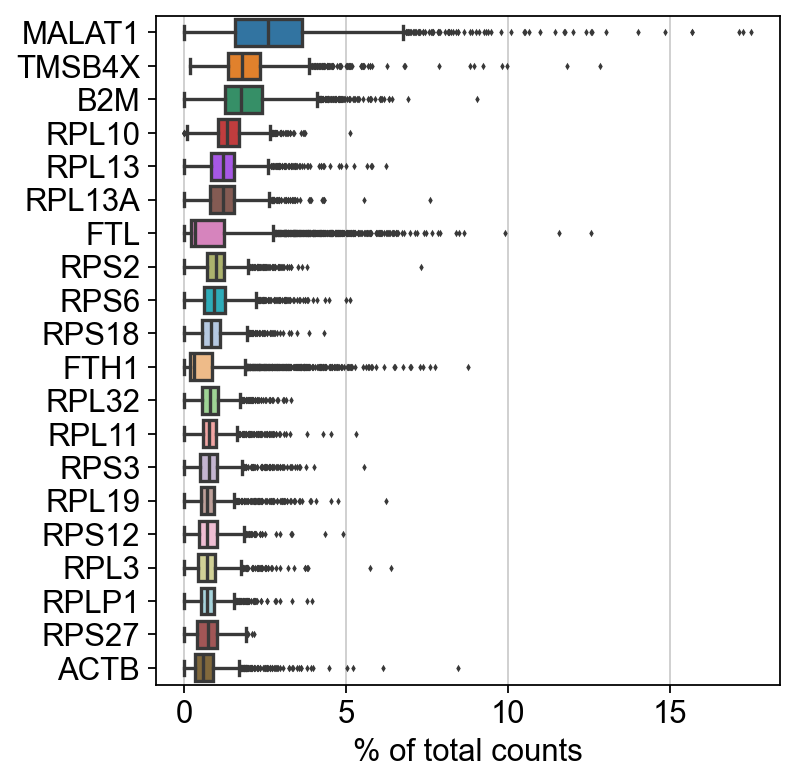

In [5]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20, )

In [6]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


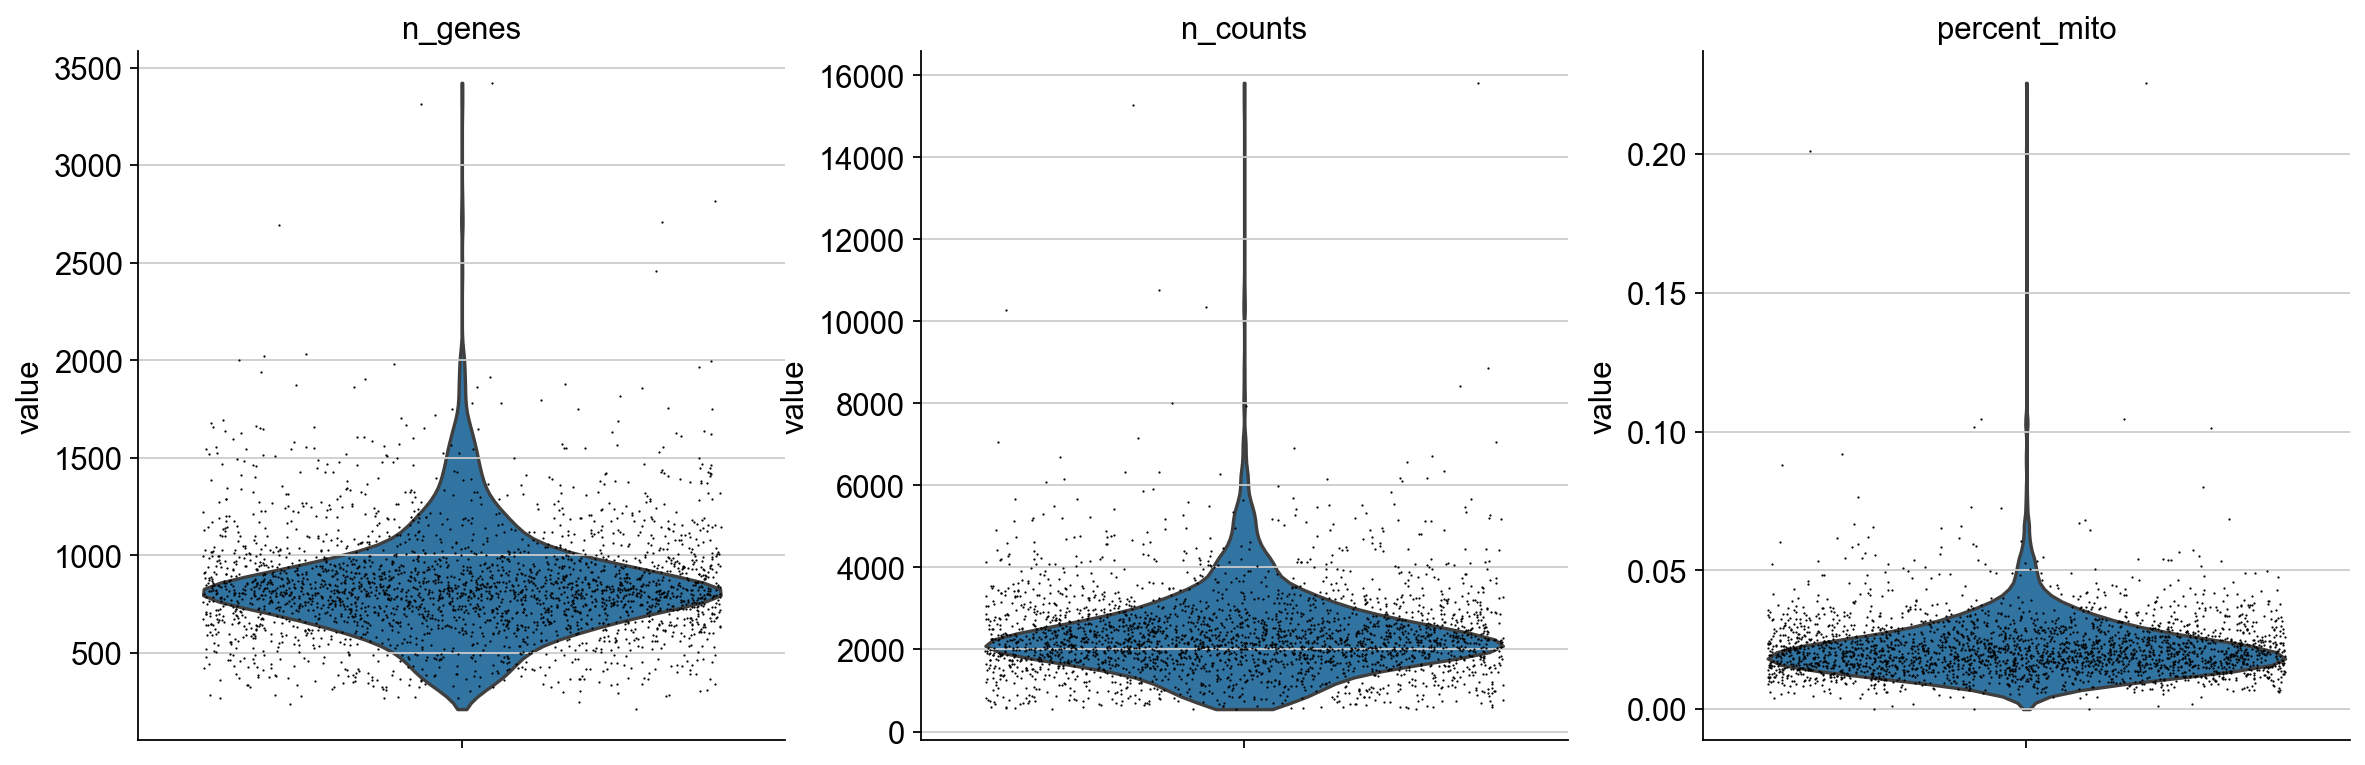

View of AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'


In [7]:
# quality control
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
                jitter=0.4, multi_panel=True)

adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]
print(adata)


In [8]:
# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(adata)


normalizing counts per cell


    finished (0:00:00)


In [9]:
# Store the raw data
adata.raw = adata

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


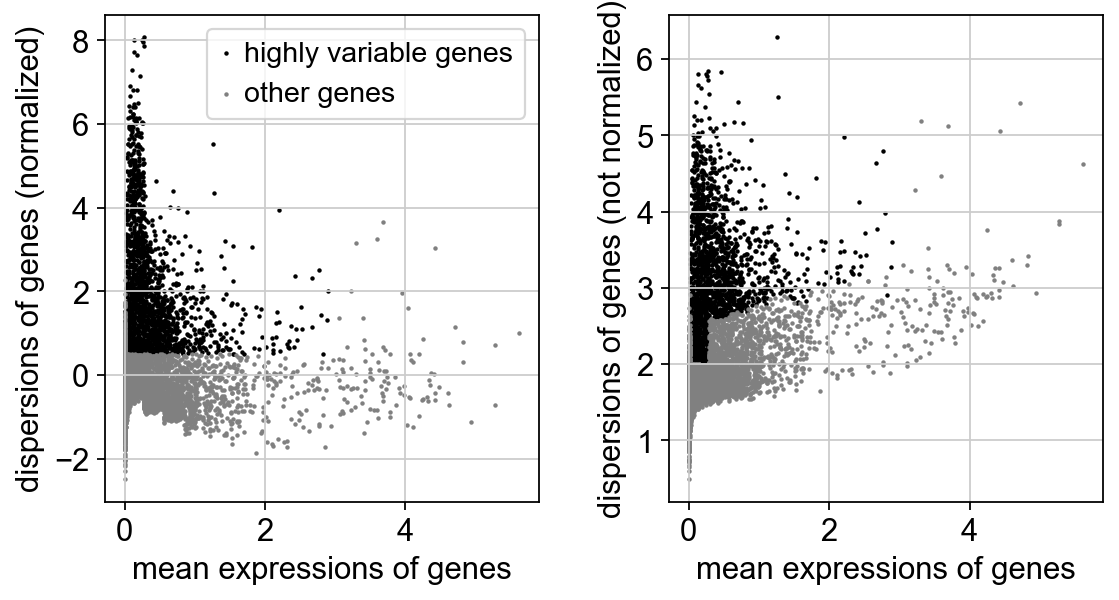

1838


In [10]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# Filter the data
adata = adata[:, adata.var.highly_variable]

# Summarize the highly variable genes
print(adata.var.highly_variable.sum())


In [11]:
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed.
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:02)


In [12]:
# Scale each gene to unit variance. Clip values exceeding standard deviation 10 to remove extreme outliers.
sc.pp.scale(adata, max_value=10)

In [13]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

## Dimension Reduction

### scPhere

In [14]:
# Import Libraries
from scphere.util.util import read_mtx
from scphere.util.trainer import Trainer
from scphere.model.vae import SCPHERE

import logging
import tensorflow as tf
from scphere.distributions import VonMisesFisher



In [ ]:
# Initialize the scPhere model with 10 latent dimensions
model = scphere.SCPhere(latent_dim=10)


In [ ]:
# Fit the model to the data
model.fit(adata)

# Embedding the data
embedding = model.transform(adata)


In [ ]:
# Visualize the embedding
# Extracting the first two dimensions
dim1 = embedding[:, 0]
dim2 = embedding[:, 1]

# Plotting the first two dimensions
plt.scatter(dim1, dim2)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('scPhere')
plt.show()


In [ ]:
# save the embedding
adata.obsm['X_scphere'] = embedding


In [ ]:
import pandas as pd

# Convert the embedding to a DataFrame
scphere_df = pd.DataFrame(embedding, index=adata.obs_names)

# Save the DataFrame to a CSV file
scphere_df.to_csv('scphere_results.csv')
